In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:

# Load and preprocess the dataset
df = pd.read_csv("/content/drive/My Drive/Dataset_PRT 564.csv")

# Aggregate data by Region and Year
df_agg = df.groupby(['Region', 'Year']).size().reset_index(name='Case_Count')

# One-hot encode categorical predictors
df_agg = pd.get_dummies(df_agg, columns=['Region'], drop_first=True)
# Replace spaces with underscores in column names
df_agg.columns = df_agg.columns.str.replace(' ', '_')

# Define regression formula
formula = 'Case_Count ~ Year + ' + ' + '.join([col for col in df_agg.columns if 'Region_' in col])

In [12]:
# Fit Poisson regression model
y, X = dmatrices(formula, df_agg, return_type='dataframe')
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

In [13]:
# Print model summaries
print("Poisson Model Summary:")
print(poisson_model.summary())

Poisson Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Case_Count   No. Observations:                  138
Model:                            GLM   Df Residuals:                       89
Model Family:                 Poisson   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -255.77
Date:                Tue, 22 Apr 2025   Deviance:                       147.30
Time:                        15:22:44   Pearson chi2:                     160.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8744
Covariance Type:            nonrobust                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [14]:
# Fit Negative Binomial model for comparison
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

print("\nNegative Binomial Model Summary:")
print(nb_model.summary())


Negative Binomial Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Case_Count   No. Observations:                  138
Model:                            GLM   Df Residuals:                       89
Model Family:        NegativeBinomial   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -284.19
Date:                Tue, 22 Apr 2025   Deviance:                       28.301
Time:                        15:22:53   Pearson chi2:                     29.9
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3723
Covariance Type:            nonrobust                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [17]:
import numpy as np
from scipy.stats import chi2

# Get log-likelihoods
ll_poisson = poisson_model.llf
ll_nb = nb_model.llf

# Compute Likelihood Ratio statistic
lr_stat = 2 * (ll_nb - ll_poisson)
df_diff = nb_model.df_model - poisson_model.df_model  # Difference in degrees of freedom
p_value = chi2.sf(lr_stat, df_diff)

# Print results
print("\nLikelihood Ratio Test:")
print(f"Test Statistic: {lr_stat:.3f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"p-value: {p_value:.3f}")



Likelihood Ratio Test:
Test Statistic: -56.829
Degrees of Freedom: 0
p-value: nan


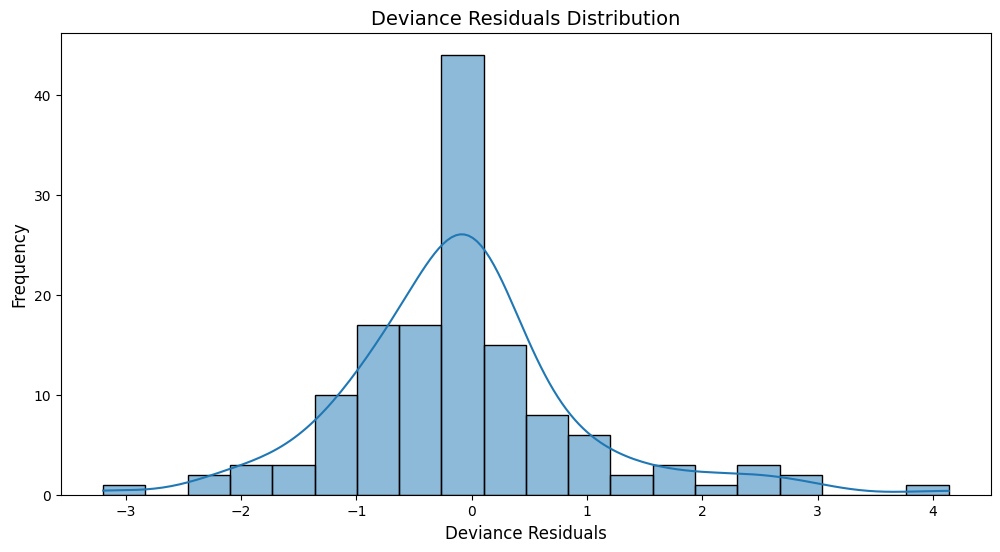

In [18]:
# Residual Analysis

plt.figure(figsize=(12, 6))
sns.histplot(poisson_model.resid_deviance, kde=True, bins=20)
plt.title("Deviance Residuals Distribution", fontsize=14)
plt.xlabel("Deviance Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()